Importing the necessary libraries that are needed

In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pylab as pl
shap.initjs()
import torch
import torch.nn as nn
import torch.optim as optim
import copy

Intsalling the transformers, dataset and torch pachages that are needed for Bert Transformer

In [ ]:
pip install transformers datasets torch

In [ ]:
pip install transformers --upgrade

Importing More Libraries of Tensorflow for the neural network model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

importing the libraries that are used in the Bert Transformer

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np


Loading the full dataset for Bert

In [ ]:
# Load full dataset for BERT
file_path = "/content/labeled_resume_dataset_noised.xlsx"
df = pd.read_excel(file_path)

# Drop unnecessary columns
df = df.drop(columns=['FirstName', 'LastName', 'Location', 'ZipCode', 'Bilingual'], errors='ignore')

# Fill missing values
df.fillna("Unknown", inplace=True)

# Combine relevant text fields for BERT input
df['text'] = df['JobTitle'] + " " + df['Bachelors'] + " " + df['Masters'] + " " + df['JobArea'] + " " + df['EstimatedEthnicity'] + " " + df['EstimatedGender']


# Encode target labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Bias_Label'])

# Split dataset (70% train, 30% test)
train_dataframe, test_dataframe = train_test_split(df[['text', 'label']], test_size=0.3, random_state=42, stratify=df['label'])

print(f"Train set size: {train_dataframe.shape}, Test set size: {test_dataframe.shape}")


Train set size: (134, 2), Test set size: (58, 2)


Loading the test and train datasets for the all remainig five models

In [ ]:
import pandas as pd

# Load the datasets
test_file_path = "/content/labeled_resume_dataset_test_noised.xlsx"
train_file_path = "/content/labeled_resume_dataset_train.xlsx"

train_df = pd.read_excel(train_file_path)
test_df = pd.read_excel(test_file_path)

# Display basic information
print("Training Data Info:")
print(train_df.info())

print("\nTesting Data Info:")
print(test_df.info())

# Display first few rows
print("\nTraining Data Sample:")
print(train_df.head())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FirstName           192 non-null    object 
 1   LastName            192 non-null    object 
 2   EstimatedEthnicity  192 non-null    object 
 3   EstimatedGender     192 non-null    object 
 4   JobTitle            192 non-null    object 
 5   JobArea             192 non-null    object 
 6   Bachelors           192 non-null    object 
 7   Masters             93 non-null     object 
 8   Location            192 non-null    object 
 9   ZipCode             182 non-null    float64
 10  Bilingual           46 non-null     object 
 11  Bias_Label          192 non-null    object 
dtypes: float64(1), object(11)
memory usage: 18.1+ KB
None

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 12 columns):
 #   Co

Droping the not used columns and filling up the missing values

In [ ]:
# Drop non-relevant columns
#train_df = train_df.drop(columns=['FirstName', 'LastName','JobTitle','Bachelors', 'Masters', 'Location', 'ZipCode', 'Bilingual'])
train_df = train_df.drop(columns=['FirstName', 'LastName','Location', 'ZipCode', 'Bilingual'])
#test_df = test_df.drop(columns=['FirstName', 'LastName','JobTitle','Bachelors', 'Masters', 'Location', 'ZipCode', 'Bilingual'])
test_df = test_df.drop(columns=['FirstName', 'LastName','Location', 'ZipCode', 'Bilingual'])

# Fill missing values with "Unknown"
train_df.fillna("Unknown", inplace=True)
test_df.fillna("Unknown", inplace=True)

# Verify if all missing values are handled
print("\nMissing Values After Cleaning:")
print(train_df.isnull().sum())



Missing Values After Cleaning:
EstimatedEthnicity    0
EstimatedGender       0
JobTitle              0
JobArea               0
Bachelors             0
Masters               0
Bias_Label            0
dtype: int64


Loading the Tokenizer that is used for Bert

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(data):
    return tokenizer(data["text"], padding="max_length", truncation=True, max_length=128)

# Convert Pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_dataframe)
test_dataset = Dataset.from_pandas(test_dataframe)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Seeing all the unquie Job Areas that are avialable in the dataset

In [ ]:
# Get the unique values of 'B' column
unique_values = train_df['JobArea'].unique()
unique_values_train = test_df['JobArea'].unique()

# Print the unique values
print("\nUnique values in JobArea column:")
print(unique_values)
print(unique_values_train)


Unique values in JobArea column:
['Marketing' 'Finance' 'Software Engineering' 'Project Management' 'Sales'
 'Mechanical Engineering']
['Software Engineering' 'Marketing' 'Project Management' 'Finance'
 'Nursing']


Encoding into categorical data using the One Hot Encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Ensure column names are stripped of whitespace
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()


# Define categorical & text features
categorical_features = ['EstimatedEthnicity', 'EstimatedGender', 'JobArea']
text_features = ['JobTitle', 'Bachelors', 'Masters']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)  # Ensuring consistency
ohe.fit(train_df[categorical_features])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)  # Ensuring consistency
ohe.fit(train_df[categorical_features])  # Fit on training data only

X_train_cat = ohe.transform(train_df[categorical_features])
X_test_cat = ohe.transform(test_df[categorical_features])  # Use transform (not fit_transform)

print(f" One-Hot Encoding - Train Shape: {X_train_cat.shape}, Test Shape: {X_test_cat.shape}")

 One-Hot Encoding - Train Shape: (192, 12), Test Shape: (49, 12)


Using the Tf-Idf for vectorization of Text Features

In [ ]:

tfidf = TfidfVectorizer(max_features=100)  # Ensure consistent max features

tfidf.fit(train_df['JobTitle'] + " " + train_df['Bachelors'] + " " + train_df['Masters'])  # Fit TF-IDF on combined train text

X_train_text = hstack([tfidf.transform(train_df[col]) for col in text_features])
X_test_text = hstack([tfidf.transform(test_df[col]) for col in text_features])  # Only transform test data

print(f" TF-IDF - Train Shape: {X_train_text.shape}, Test Shape: {X_test_text.shape}")



 TF-IDF - Train Shape: (192, 258), Test Shape: (49, 258)


Combing the text and categorical features into final test and train sets

In [ ]:
# Combine all features
X_train = hstack([X_train_cat, X_train_text])
X_test = hstack([X_test_cat, X_test_text])

print(f" Final Feature Shapes - Train: {X_train.shape}, Test: {X_test.shape}")

# Verify if feature mismatch still exists
if X_train.shape[1] != X_test.shape[1]:
    print(f" Feature mismatch! Train has {X_train.shape[1]} features, Test has {X_test.shape[1]}")
else:
    print(" Feature count matches!")

 Final Feature Shapes - Train: (192, 270), Test: (49, 270)
 Feature count matches!


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert Bias_Label column to numeric
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Bias_Label'])
y_test = label_encoder.transform(test_df['Bias_Label'])

print("Target variable converted successfully!")
print(f"Unique values in y_train: {set(y_train)}")
print(f"Unique values in y_test: {set(y_test)}")

Target variable converted successfully!
Unique values in y_train: {np.int64(0), np.int64(1)}
Unique values in y_test: {np.int64(0), np.int64(1)}


The first model used is the random forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.79      0.55      0.65        20
           1       0.74      0.90      0.81        29

    accuracy                           0.76        49
   macro avg       0.76      0.72      0.73        49
weighted avg       0.76      0.76      0.74        49



The second model used is the XGBoost model

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Train XGBoost Model (Without use_label_encoder)
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluation
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.61      0.55      0.58        20
           1       0.71      0.76      0.73        29

    accuracy                           0.67        49
   macro avg       0.66      0.65      0.66        49
weighted avg       0.67      0.67      0.67        49



The third model used is the MLP(mutli level perceptron) Classifier model

In [ ]:
from sklearn.neural_network import MLPClassifier

# Train MLP Neural Network
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test)

# Evaluation
print("Neural Network Performance:")
print(classification_report(y_test, y_pred_mlp))


Neural Network Performance:
              precision    recall  f1-score   support

           0       0.69      0.55      0.61        20
           1       0.73      0.83      0.77        29

    accuracy                           0.71        49
   macro avg       0.71      0.69      0.69        49
weighted avg       0.71      0.71      0.71        49



The fourth model used is the custom built model with three layer and with relu activation function

In [ ]:
# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # Input Layer
    Dropout(0.4),  # Prevent overfitting
    Dense(128, activation='relu'),  # Hidden Layer 1
    Dropout(0.3),
    Dense(64, activation='relu'),  # Hidden Layer 2
    Dense(1, activation='sigmoid')  # Output Layer (Binary Classification)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the custom built model

In [ ]:
# Train the model
history = model.fit(X_train.toarray(), y_train,  # Convert sparse matrix to array
                    epochs=100, batch_size=32,
                    validation_data=(X_test.toarray(), y_test),
                    verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.4531 - loss: 0.7053 - val_accuracy: 0.6122 - val_loss: 0.6626
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6726 - loss: 0.6547 - val_accuracy: 0.5918 - val_loss: 0.6447
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6775 - loss: 0.6254 - val_accuracy: 0.5918 - val_loss: 0.6318
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6655 - loss: 0.6202 - val_accuracy: 0.6122 - val_loss: 0.6196
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6946 - loss: 0.5965 - val_accuracy: 0.7143 - val_loss: 0.6040
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7449 - loss: 0.5619 - val_accuracy: 0.7347 - val_loss: 0.5908
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7846 - loss: 0.5399 - val_accuracy: 0.7347 - val_loss: 0.5795
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7565 - loss: 0.5073 - val_accuracy: 0.7347 - val_loss

 Evaluating the Custom Built model

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test.toarray(), y_test)
print(f"\n Test Accuracy: {test_acc:.4f}")

# Make predictions
y_pred_nn = (model.predict(X_test.toarray()) > 0.5).astype(int)

# Classification Report
print("Neural Network Performance:")
print(classification_report(y_test, y_pred_nn))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7190 - loss: 1.5875

 Test Accuracy: 0.7347
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Neural Network Performance:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65        20
           1       0.75      0.83      0.79        29

    accuracy                           0.73        49
   macro avg       0.73      0.71      0.72        49
weighted avg       0.73      0.73      0.73        49



# Visualization
To show the accuracy and loss for train and validation

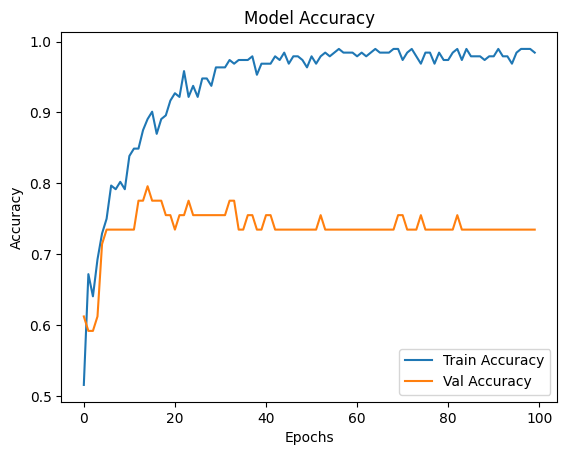

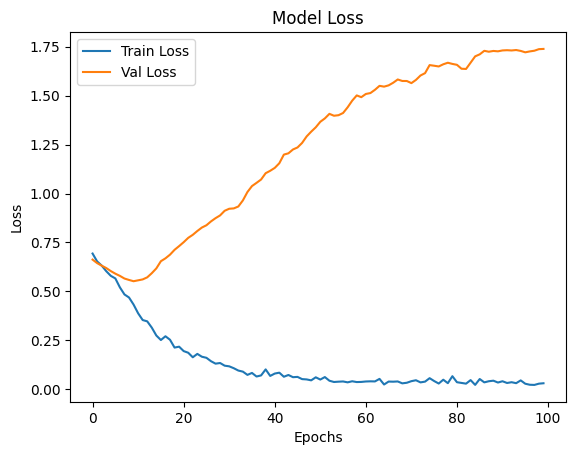

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Model Loss")
plt.show()


Load and train the Bert Model trainer. here we need wamdb.ai api key for using the Bert Tranformer

In [ ]:
from transformers import (
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score
import torch

# --- Configuration ---
MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2
BATCH_SIZE = 16
MAX_LENGTH = 512

# --- Model Loading ---
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True  # Silences classifier weight warnings
)

# --- Fixed Training Arguments ---
training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=500,
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE*2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
    report_to="none",
    optim="adamw_torch",
    dataloader_num_workers=2,     # Added for data loading optimization
    remove_unused_columns=True    # Reduces memory usage
)

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding="longest",
    max_length=MAX_LENGTH,
    pad_to_multiple_of=8
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

if torch.cuda.is_available():
    model = model.to("cuda")

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


TrainOutput(global_step=12, training_loss=0.5650905768076578, metrics={'train_runtime': 563.1276, 'train_samples_per_second': 0.714, 'train_steps_per_second': 0.021, 'total_flos': 21838217594880.0, 'train_loss': 0.5650905768076578, 'epoch': 2.4444444444444446})

n

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print("Model Evaluation:", results)

# Make predictions
predictions = trainer.predict(test_dataset)

# Convert logits to labels
pred_labels = np.argmax(predictions.predictions, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print("BERT Model Performance:")
print(classification_report(test_dataframe['label'], pred_labels))


Model Evaluation: {'eval_loss': 0.5092952251434326, 'eval_accuracy': 0.8103448275862069, 'eval_f1': 0.801945181255526, 'eval_runtime': 25.3019, 'eval_samples_per_second': 2.292, 'eval_steps_per_second': 0.079, 'epoch': 2.4444444444444446}
BERT Model Performance:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       0.79      0.94      0.86        35

    accuracy                           0.81        58
   macro avg       0.83      0.78      0.79        58
weighted avg       0.82      0.81      0.80        58

